In [1]:
import pandas as pd
from rdkit import Chem
import math
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from tdc.single_pred import ADME
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs
tqdm.pandas()

In [2]:
sol_df = pd.read_csv('./data/noduplicates.csv')

In [3]:
def standardize(smiles):
    # Borrowed from Pat Walter's Practical Cheminformatics Tutorial
    mol = Chem.MolFromSmiles(smiles)
     
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
     
    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.
     
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
     
    return taut_uncharged_parent_clean_mol

You obsereved the different SMILES for the same name in the previous notebook. In some cases the SMILES need to be standardized / canonicalized. Lets convert our SMILES to rdkit molecule objects and then standardize them. 

In [4]:
block = BlockLogs()
sol_df['mol'] = sol_df.SMILES.progress_apply(standardize)
del block

  0%|          | 0/9892 [00:00<?, ?it/s]

In [5]:
from rdkit.Chem import rdMolDescriptors #molecular descriptors

In [6]:
property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

In [7]:
len(property_names)

43

In [8]:
property_names

['exactmw',
 'amw',
 'lipinskiHBA',
 'lipinskiHBD',
 'NumRotatableBonds',
 'NumHBD',
 'NumHBA',
 'NumHeavyAtoms',
 'NumAtoms',
 'NumHeteroatoms',
 'NumAmideBonds',
 'FractionCSP3',
 'NumRings',
 'NumAromaticRings',
 'NumAliphaticRings',
 'NumSaturatedRings',
 'NumHeterocycles',
 'NumAromaticHeterocycles',
 'NumSaturatedHeterocycles',
 'NumAliphaticHeterocycles',
 'NumSpiroAtoms',
 'NumBridgeheadAtoms',
 'NumAtomStereoCenters',
 'NumUnspecifiedAtomStereoCenters',
 'labuteASA',
 'tpsa',
 'CrippenClogP',
 'CrippenMR',
 'chi0v',
 'chi1v',
 'chi2v',
 'chi3v',
 'chi4v',
 'chi0n',
 'chi1n',
 'chi2n',
 'chi3n',
 'chi4n',
 'hallKierAlpha',
 'kappa1',
 'kappa2',
 'kappa3',
 'Phi']

In [9]:
import numpy as np

In [10]:
def calc_descriptors(mol):
    props = None
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        props = np.array(property_getter.ComputeProperties(mol))
    return props

In [11]:
sol_df['props'] = sol_df.mol.progress_apply(calc_descriptors)

  0%|          | 0/9892 [00:00<?, ?it/s]

In [12]:
sol_df.head()

,Name,SMILES,LogS,mol,props
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,<rdkit.Chem.rdchem.Mol object at 0x158726a40>,"[312.36247689209, 312.60599999999994, 1.0, 0.0..."
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x158726f10>,"[169.052763844, 169.18299999999996, 2.0, 1.0, ..."
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x158726f80>,"[140.00289246, 140.569, 1.0, 0.0, 1.0, 0.0, 1...."
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,<rdkit.Chem.rdchem.Mol object at 0x158726e30>,"[346.15689456399997, 346.426, 3.0, 2.0, 5.0, 2..."
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x158726ff0>,"[422.22055743999994, 422.52500000000026, 6.0, ..."


In [13]:
len(sol_df.props[0])

43

In [14]:
sol_df[property_names] = sol_df['props'].to_list()

In [15]:
sol_df.head(4)

,Name,SMILES,LogS,mol,props,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,<rdkit.Chem.rdchem.Mol object at 0x158726a40>,"[312.36247689209, 312.60599999999994, 1.0, 0.0...",312.362477,312.606,1.0,0.0,17.0,...,16.468029,10.364975,4.682488,4.682488,3.134242,-0.04,21.960000,15.840489,19.960000,15.811688
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x158726f10>,"[169.052763844, 169.18299999999996, 2.0, 1.0, ...",169.052764,169.183,2.0,1.0,0.0,...,6.872350,4.192158,2.397526,2.397526,1.824022,-1.83,6.660756,2.102073,0.745786,1.077031
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x158726f80>,"[140.00289246, 140.569, 1.0, 0.0, 1.0, 0.0, 1....",140.002892,140.569,1.0,0.0,1.0,...,4.672964,2.534727,1.006088,1.006088,0.541348,-0.82,6.302249,2.646097,1.541347,1.852930
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,<rdkit.Chem.rdchem.Mol object at 0x158726e30>,"[346.15689456399997, 346.426, 3.0, 2.0, 5.0, 2...",346.156895,346.426,3.0,2.0,5.0,...,14.885579,8.686807,4.957790,4.957790,3.278652,-3.07,17.743397,7.441537,3.472429,5.078390


Check for constant columns, null values, outliers, etc.

In [16]:
for i in property_names:
    if sol_df[i].isnull().sum()!=0:
        print(i)

No null values

In [17]:
sol_df.describe()

,LogS,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
count,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,...,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000
mean,-2.887576,249.157909,249.563405,3.861504,1.356247,3.900425,1.193389,3.205722,16.515871,31.496159,...,9.498662,5.340709,2.593232,2.593232,1.717147,-1.284922,12.694512,5.665393,18.820200,4.580356
std,2.371825,150.108085,150.384228,3.486303,1.744717,4.908782,1.531097,2.924320,10.279594,20.409514,...,5.926253,3.600061,2.170721,2.170721,1.659611,1.287152,7.902150,5.037575,293.851658,4.718118
min,-13.171900,9.012182,9.012000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-10.980000,0.000000,-27.040000,-104.040000,-25.958400
25%,-4.324125,154.010322,154.116250,2.000000,0.000000,1.000000,0.000000,1.000000,10.000000,19.000000,...,5.902675,3.146037,1.253322,1.253322,0.695976,-1.910000,7.862459,3.136157,1.822699,2.331576
50%,-2.602550,221.103182,221.260000,3.000000,1.000000,3.000000,1.000000,3.000000,15.000000,27.000000,...,8.403947,4.683975,2.107808,2.107808,1.305305,-1.140000,11.285700,4.778881,2.961173,3.630440
75%,-1.205005,307.121790,308.028000,5.000000,2.000000,5.000000,2.000000,4.000000,20.000000,39.000000,...,11.717075,6.703708,3.332055,3.332055,2.219370,-0.490000,15.429241,6.848428,4.809329,5.472115
max,2.137682,2284.054626,2285.676000,45.000000,24.000000,68.000000,24.000000,40.000000,164.000000,414.000000,...,114.976336,66.171161,43.297267,43.297267,31.174906,3.480000,135.688045,70.920000,18691.481020,69.870773


In [18]:
sol_df.drop(['props'], axis=1, inplace=True)

In [19]:
sol_df.head(4)

,Name,SMILES,LogS,mol,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,<rdkit.Chem.rdchem.Mol object at 0x158726a40>,312.362477,312.606,1.0,0.0,17.0,0.0,...,16.468029,10.364975,4.682488,4.682488,3.134242,-0.04,21.960000,15.840489,19.960000,15.811688
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x158726f10>,169.052764,169.183,2.0,1.0,0.0,1.0,...,6.872350,4.192158,2.397526,2.397526,1.824022,-1.83,6.660756,2.102073,0.745786,1.077031
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x158726f80>,140.002892,140.569,1.0,0.0,1.0,0.0,...,4.672964,2.534727,1.006088,1.006088,0.541348,-0.82,6.302249,2.646097,1.541347,1.852930
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,<rdkit.Chem.rdchem.Mol object at 0x158726e30>,346.156895,346.426,3.0,2.0,5.0,2.0,...,14.885579,8.686807,4.957790,4.957790,3.278652,-3.07,17.743397,7.441537,3.472429,5.078390


Lets add a dummy column with all 1s

In [20]:
sol_df['dummy'] = np.ones(len(sol_df))

In [21]:
sol_df.head(4)

,Name,SMILES,LogS,mol,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,...,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi,dummy
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,<rdkit.Chem.rdchem.Mol object at 0x158726a40>,312.362477,312.606,1.0,0.0,17.0,0.0,...,10.364975,4.682488,4.682488,3.134242,-0.04,21.960000,15.840489,19.960000,15.811688,1.0
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x158726f10>,169.052764,169.183,2.0,1.0,0.0,1.0,...,4.192158,2.397526,2.397526,1.824022,-1.83,6.660756,2.102073,0.745786,1.077031,1.0
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x158726f80>,140.002892,140.569,1.0,0.0,1.0,0.0,...,2.534727,1.006088,1.006088,0.541348,-0.82,6.302249,2.646097,1.541347,1.852930,1.0
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,<rdkit.Chem.rdchem.Mol object at 0x158726e30>,346.156895,346.426,3.0,2.0,5.0,2.0,...,8.686807,4.957790,4.957790,3.278652,-3.07,17.743397,7.441537,3.472429,5.078390,1.0


In [22]:
sol_df.shape

(9892, 48)

Removing all constant columns, or rather keeping only those columns which are not constant.

In [23]:
sol_df = sol_df.loc[:,sol_df.apply(pd.Series.nunique) != 1]

In [24]:
sol_df.shape

(9892, 45)

In [25]:
sol_df.head(4)

,Name,SMILES,LogS,mol,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,<rdkit.Chem.rdchem.Mol object at 0x158726a40>,312.362477,312.606,1.0,0.0,17.0,0.0,...,16.468029,10.364975,4.682488,4.682488,3.134242,-0.04,21.960000,15.840489,19.960000,15.811688
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x158726f10>,169.052764,169.183,2.0,1.0,0.0,1.0,...,6.872350,4.192158,2.397526,2.397526,1.824022,-1.83,6.660756,2.102073,0.745786,1.077031
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x158726f80>,140.002892,140.569,1.0,0.0,1.0,0.0,...,4.672964,2.534727,1.006088,1.006088,0.541348,-0.82,6.302249,2.646097,1.541347,1.852930
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,<rdkit.Chem.rdchem.Mol object at 0x158726e30>,346.156895,346.426,3.0,2.0,5.0,2.0,...,14.885579,8.686807,4.957790,4.957790,3.278652,-3.07,17.743397,7.441537,3.472429,5.078390


2 other columns were removed

In [26]:
set(property_names) - set(sol_df.columns)

{'NumAtomStereoCenters', 'NumUnspecifiedAtomStereoCenters'}

<Axes: xlabel='LogS', ylabel='NumRotatableBonds'>

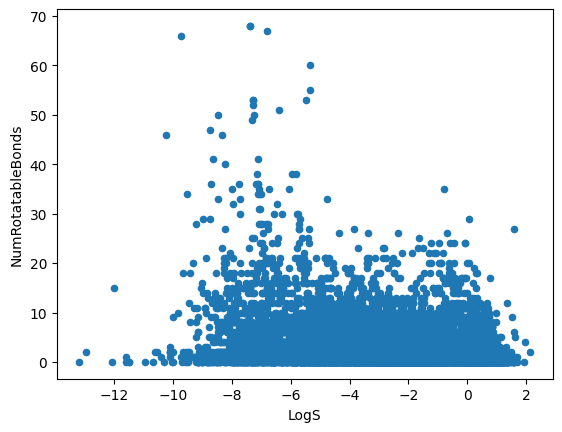

In [27]:
sol_df.plot(kind='scatter',x='LogS',y='NumRotatableBonds')

Possibly analyze the variance of each descriptor

In [28]:
vars = []
for i in sol_df.columns[4:]:
    vars.append(sol_df[i].var())

In [29]:
vars

[22532.43727261703,
 22615.416143199385,
 12.154308039310655,
 3.044038409279832,
 24.096139744893417,
 2.3442571645166033,
 8.551648584205937,
 105.67005441193359,
 416.548261452174,
 15.645266972474701,
 0.5500561048710361,
 0.1258863282458863,
 2.340470724508137,
 1.5427732339107678,
 1.003875727025876,
 0.7174514786997112,
 0.7674076467053356,
 0.2810251228892297,
 0.40601153462347345,
 0.4880293459934475,
 0.011617287552805158,
 0.2009938658919628,
 3577.916825091155,
 2935.2248049003642,
 6.46850681182686,
 1556.7181897903304,
 37.56599718801976,
 16.17440729523736,
 7.4566379529334235,
 7.4566379529334235,
 4.998696420348953,
 35.12046938229654,
 12.960439857386628,
 4.71203170234446,
 4.71203170234446,
 2.7543076444264494,
 1.6567600071265016,
 62.443976652810456,
 25.377158774761817,
 86348.79698801672,
 22.260633630508085]

In [30]:
sol_df.to_csv('./data/with_features.csv', index=False)